# *BASECODE 작성 (LGBM 기반)*

* 가상환경 activate 후 lightgbm 설치
* conda install -c conda-forge lightgbm

In [79]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제

In [80]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

### 데이터 전처리
http://www.dodomira.com/2016/10/20/how_to_eda/ 

링크 참고 

## 1. **데이터 셋 확인**

* 이전 EDA 코드 돌려봤기에 코드를 직접 합치지는 않았음

In [81]:
train.info()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [93]:
# 각 유형 갯수 확인
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

[8, 7, 4]

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [82]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

훈련데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64
테스트데이터 결측치 합 
 gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64


In [83]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
train.fillna('NAN', inplace=True) 
test.fillna('NAN', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())


훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

In [89]:
display(len(train.columns))
display((train.columns))

19

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 연간 소득, 출생일, 업무 시작일, 가족 규모, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 아이 숫자
* 6명 이상의 자녀를 가진 사람은 5명으로 변경 -> 이유: test set에서 자녀의 수 max가 5 이기 때문. 

In [102]:
print('train childnum unique:', train['child_num'].unique())

train childnum unique: [0 1 2 3 4 5]


In [101]:
print('test childnum unique:', test['child_num'].unique())

test childnum unique: [0 1 2 3 5 4]


childnum unique: [0 1 2 3 4 5]


<AxesSubplot:xlabel='child_num'>

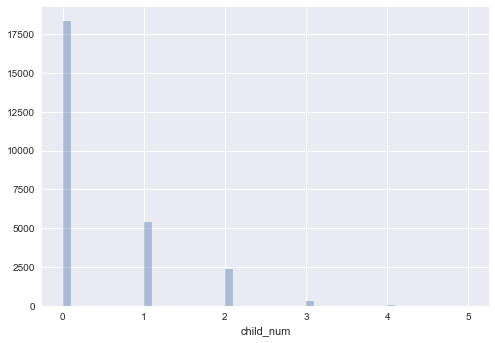

In [110]:
# 아이가 6명 이상인 데이터는 5로 변경
train.loc[train['child_num'] >= 6,'child_num']=5
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모
* 1의 이유와 같이 최대 아이 숫자를 5로 했기 때문에 가족 규모의 최댓값도 7로 변경함

In [105]:
print('train familysize unique:', train['family_size'].unique())

train familysize unique: [ 2.  3.  4.  1.  5.  6.  7. 15. 20.  9.]


In [106]:
train.loc[train['family_size'] >= 8,'family_size']=7

train familysize unique: [2. 3. 4. 1. 5. 6. 7.]


<AxesSubplot:xlabel='family_size'>

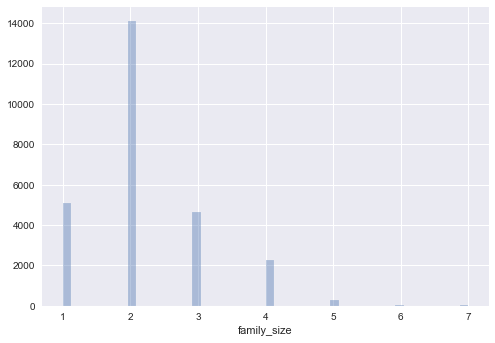

In [111]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있는데.. 지워도 되는지 모르겠음.

Text(0.5, 1.0, 'test Boxplot of income_total')

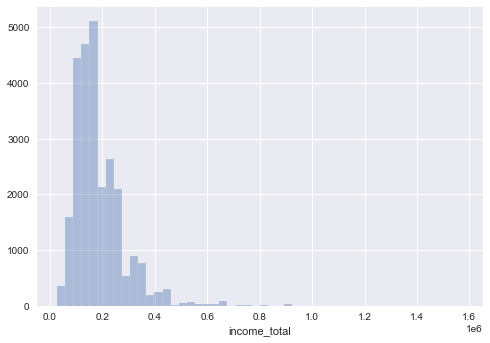

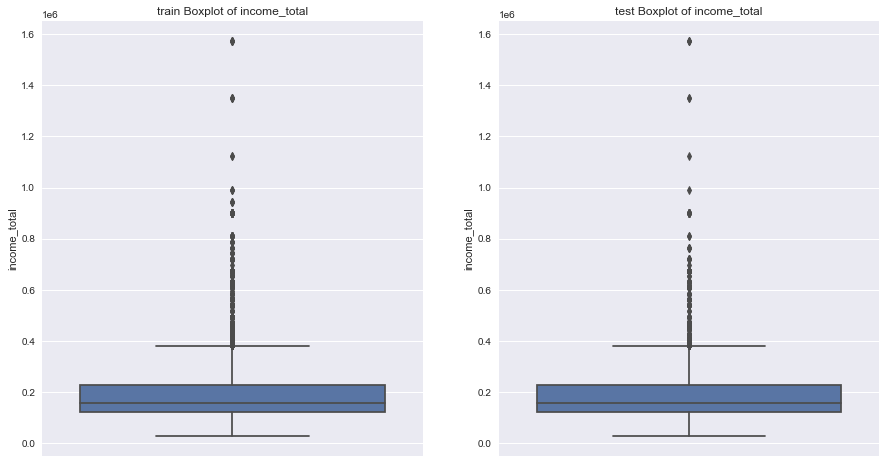

In [128]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일
* 양수로해서 365 나눠야함

#### 5) 업무시작일
* 양수로..

#### 6) 신용카드 발급 월

#### 박스플롯 그리는 코드 (x를 지워야 맞는거 같기도 하고...)

In [ ]:
# begin_month, DAYS_BIRTH
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=train['credit'], y=train["begin_month"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of begin_month")

sns.boxplot(x=train['credit'], y=train["DAYS_BIRTH"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of DAYS_BIRTH")

In [ ]:
# income_total, DAYS_EMPLOYED
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=train['credit'], y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of income_total")

sns.boxplot(x=train['credit'], y=train["DAYS_EMPLOYED"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of DAYS_EMPLOYED")

In [ ]:
# child_num, family_size
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(x=train['credit'], y=train["child_num"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of child_num")

sns.boxplot(x=train['credit'], y=train["family_size"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of family_size")

### 상관분석 코드

In [ ]:
#상관관계를 확인 후 목표변수에 영향을 많이 미치는 컬럼에서 이상치 제거
sns.set(rc={'figure.figsize':(14,8)})
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [ ]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = train.corr()
IF = Corr['credit'].sort_values().to_frame()
display(IF.head(5))
print(IF)

## 4. **Feature Engineering** - 여기에 정규화 포함시켜야 할듯요!

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 범주형 데이터 one-hot encoding
* object (범주형)은 원핫인코딩 하기.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [ ]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)
display(object_col)

In [ ]:
# 모든 object객체 열을 onehot encoding 하였음.
# train 데이터 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [ ]:
# 인코딩 확인
display(train.head(5))
print(train.columns)

In [ ]:
# test 데이터 onehot encoding

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [ ]:
display(test)

-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

## 이후부터는 모델 훈련 및 모델링 코드

* <>
* <>
* <>
* <>
* <>
* <>

* <>
* <>
* <>
* <>
* <>
* <>

### 모델 훈련

In [ ]:
# StratifiedKFold - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
# 5-fold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
# 30번 이상 개선 없을 시 중단
# 5개의 fold를 훈련하여 저장
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [ ]:
submit.to_csv('./20210416_test_submit_ensemble.csv', index=False) # 0.7272812144

In [ ]:
submit.head(20)